### Use CIGALE to fit the COSMOS2020 SEDs for HSC-SSP AGNs

In [ ]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [ ]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

### Read the updated HSC-SSP AGN table:

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [ ]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
data_agn
# TODO: Also read Chandra COSMOS legacy and re-do Mar's analysis

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,2016ApJ...817...34M
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.503096,1,592797,PDR3 miscellaneous
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.9769,1,565402,PDR3 miscellaneous
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.5727,1,552225,PDR3 miscellaneous
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.5847,1,589540,PDR3 miscellaneous
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.6633,1,625595,PDR3 miscellaneous
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964449,1,689768,PDR3 miscellaneous
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.995,1,782508,PDR3 miscellaneous
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.474,3,445280,2016ApJ...817...34M


In [17]:
print(filt_use)

['CHANDRA', 'GALEX_FUV', 'GALEX_NUV', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']


### Generate the CIGALE input files

In [19]:
data_phot = []
fluxes = []
fluxes_err = []

# Add ID
data_phot.append(list(range(len(idx_COSMOS20))))

# Add redshifts
z = data_cosmos2020j['ez_z_phot'][idx_COSMOS20].data.data # Use ez photo-z first

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 3
mask_xray = data_agn['X-flag'][idx_agn2COSMOS20] == 1

z[mask_spec] = data_agn['z'][idx_agn2COSMOS20][mask_spec].data.data
z[z>6] = 0
z[z<0] = 0
z[~np.isfinite(z)] = 0

data_phot.append(z)

for b in filt_use:
    fluxes.append(data_cosmos2020j[b+'_FLUX'][idx_COSMOS20].data.data*1e-3) # mJy
    data_phot.append(data_cosmos2020j[b+'_FLUX'][idx_COSMOS20].data.data*1e-3) # mJy
    
for b in filt_use:
    fluxes_err.append(data_cosmos2020j[b+'_FLUXERR'][idx_COSMOS20].data.data*1e-3) # mJy
    data_phot.append(data_cosmos2020j[b+'_FLUXERR'][idx_COSMOS20].data.data*1e-3) # mJy

data_phot = np.array(data_phot)
fluxes = np.array(fluxes)
fluxes_err = np.array(fluxes_err)

fmt = '%d ' + ' '.join(['%0.8f']*(len(filt_use)*2 + 1))

print(data_phot.shape)

# Replace invalid values
data_phot[data_phot<0,] = -9999
data_phot[~np.isfinite(data_phot),] = -9999

print(data_phot.shape)
print(len(fmt.split()))

hdr = 'id redshift xray_boxcar_2to10keV galex.FUV galex.NUV cfht.megacam.u subaru.hsc.g subaru.hsc.r subaru.hsc.i subaru.hsc.z subaru.hsc.y vista.vircam.Y vista.vircam.J vista.vircam.H vista.vircam.Ks IRAC1 IRAC2 IRAC3 IRAC4 xray_boxcar_2to10keV_err galex.FUV_err galex.NUV_err cfht.megacam.u_err subaru.hsc.g_err subaru.hsc.r_err subaru.hsc.i_err subaru.hsc.z_err subaru.hsc.y_err vista.vircam.Y_err vista.vircam.J_err vista.vircam.H_err vista.vircam.Ks_err IRAC1_err IRAC2_err IRAC3_err IRAC4_err'

print('hdr:', len(hdr.split(',')))

# Save
np.savetxt('cigale/hsc/phot.dat', data_phot.T, header=hdr, fmt=fmt)

(36, 455)
(36, 455)
36
hdr: 1


In [20]:
print(len(data_cosmos2020['IRAC_CH2_FLUX'].data.data*1e-3))
print(len(data_cosmos2020[data_cosmos2020['IRAC_CH2_FLUX'].data.data*1e-3>0]))

964506
713836


In [21]:
print(len(data_cosmos2020['GALEX_FUV_FLUX'].data.data*1e-3))
print(len(data_cosmos2020[data_cosmos2020['GALEX_FUV_FLUX'].data.data*1e-3>0]))

964506
77948


### Run Cigale 


### Plot the CIGALE SEDs

In [22]:
from matplotlib import gridspec

# Plotting function
def plot_results(filt_use):

    # Plot output
    hdul = fits.open('./cigale/hsc/fagn1/out/results.fits')
    results_fagn1 = hdul[1].data

    hdul = fits.open('./cigale/hsc/float/out/results.fits')
    results = hdul[1].data
        
    central_wavelengths = np.array([filt_dict[k][0] for k in filt_use])*1e-4 # um
    
    for i, row in enumerate(results): # Don't change this
            
        # Why??
        if np.log10(results['bayes.stellar.m_star'][i]) < 0:
            continue
            
        # Chi^2
        print(results_fagn1['best.reduced_chi_square'][i])
        if (results_fagn1['best.reduced_chi_square'][i] - results['best.reduced_chi_square'][i]) > 1.5:
            continue
            
        if (results_fagn1['best.reduced_chi_square'][i]) > 5:
            continue
        
        flux = fluxes[:,i]
        flux_err = fluxes_err[:,i]
        
        # Add 0.2 mag err
        dm = 0.2
        flux_err = np.sqrt(flux_err**2 + (np.log(10)/2.5*flux*dm)**2)
        
        if np.all(~np.isfinite(flux)):
            print('continue')
            continue
        
        # Gridspec
        gs = gridspec.GridSpec(2, 1, wspace=0.0, hspace=0, 
                               height_ratios=[4, 1])
        #gs.update(wspace=0.0, hspace=0)

        fig = plt.figure(figsize=(8, 5))
        #fig, ax = plt.subplots(figsize=(6, 4))
        #fig.subplots_adjust(hspace=.0)
        
        # Coadd image
        """
        #ax = fig.add_subplot(gs[0,:6])
        #ax.imshow(rgb, origin='lower')
        #ax.axis('off')
        
        #target_name = 'J{0}{1}'.format(c.ra.to_string(unit=u.hourangle, sep='', precision=1, pad=True),
        #                               c.dec.to_string(sep='', precision=1, alwayssign=True, pad=True))
        #ax.text(0.02, 0.9, target_name, transform=ax.transAxes, color='w')
        
        scale = 5*u.arcsec
        ps = 0.2637*u.arcsec
        s = np.shape(rgb)[0]
        size = scale/(ps*s) #/s # normalized to one
        # compass
        xy0 = np.array([.95,.05])
        xy1 = [xy0[0], xy0[1]+.25]
        ax.annotate('N', xy0, xy1, ax.transAxes, ax.transAxes,
                    ha='center', va='center', c='w', fontsize=12,
                    arrowprops=dict(arrowstyle='<-', color='w', lw=2,
                                    shrinkA=0.0, shrinkB=0.0))
        xy1 = [xy0[0]-.25, xy0[1]]
        ax.annotate('E', xy0, xy1, ax.transAxes, ax.transAxes,
                    ha='center', va='center', c='w', fontsize=12,
                    arrowprops=dict(arrowstyle='<-', color='w', lw=2,
                                    shrinkA=0.0, shrinkB=0.0))
        xy0 = np.array([.05,.05])
        xy1 = [xy0[0]+size, xy0[1]]
        ax.annotate('5\'\'', xy0, xy1, ax.transAxes, ax.transAxes,
                    ha='center', va='center', c='w', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='w', lw=2,
                                    shrinkA=0.0, shrinkB=0.0))
        """
        
        # SED
        ax = fig.add_subplot(gs[0,:])

        # Make sure to update filename
        hdul = fits.open(f'./cigale/hsc/float/out/{i}_best_model.fits')
        data = hdul[1].data
        
        hdul = fits.open(f"./cigale/hsc/fagn1/out/{i}_best_model.fits")
        data_fagn1 = hdul[1].data

        print('f_agn', results['best.agn.fracAGN'][i])
        
        d_L = results['best.universe.luminosity_distance'][i]*u.m
        m_star = np.around(np.log10(results['bayes.stellar.m_star'][i]), 1)
        print(m_star)
        m_star_err = np.around(0.434*results['bayes.stellar.m_star_err'][i]/results['bayes.stellar.m_star'][i], 1)
        m_star_err =  np.clip(m_star_err, 0.1, None) # Set min error to 0.1
        
        redshift = np.around(z[i], 2)
        #photoz_err1 = photoz - np.around(row['photoz_err1'], 2)
        #photoz_err2 = np.around(row['photoz_err2'], 2) - photoz
        chi2nu = np.around(results['best.reduced_chi_square'][i], 2)
        chi2nu_fagn1 = np.around(results_fagn1['best.reduced_chi_square'][i], 2)

        # Get model photometry
        names = results.columns.names[-len(central_wavelengths):]
        modelFnu = [results[name][i] for name in names]
        toFnu = 1/(4*np.pi*d_L**2).to(u.m**2).value * data['wavelength'] / (const.c/(data['wavelength']*u.nm)).to(u.Hz).value * 1e3 * 1e26 # W / nm -> mJy
        # k-correction
        wav = data['wavelength']*1e-3 
        
        ax.text(0.98, 0.2, r'$M_{\ast}=10^{%0.1f{\pm}%0.1f}\ M_{\odot}$' % (m_star, m_star_err), fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.98, 0.1, r'$z = {%0.2f}^{+%0.2f}_{-%0.2f}$' % (redshift, 0, 0), fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        
        # Plot
        ax.loglog(wav, data['Fnu'], color='k', label='total model', zorder=10, lw=2, linestyle='dashed')
        ax.loglog(wav, data_fagn1['Fnu'], color='gray', label=r'total $f_{\rm{AGN}}{=}1$ model', zorder=-1, lw=5)
        
        #ax.loglog(data['wavelength']*1e-3, (data['stellar.old'] + data['stellar.young'])*toFnu, color='blue', linestyle='dotted', label='Stellar unattenuated')
        stellar_att = data['xray.galaxy'] + data['stellar.old'] + data['stellar.young'] + data['attenuation.stellar.old'] + data['attenuation.stellar.young'] + data['nebular.absorption_old'] + data['nebular.absorption_young']
        ax.loglog(wav, stellar_att*toFnu, color='royalblue', label='Stellar')
        neb_att = data['nebular.lines_old'] + data['nebular.lines_young'] + \
                   data['nebular.continuum_old'] + data['nebular.continuum_young']
        #ax.loglog(data['wavelength']*1e-3, neb_att*toFnu, color='peru', label='Nebular')
        ax.loglog(wav, (data['dust.Umin_Umin'] + data['dust.Umin_Umax'])*toFnu, color='darkred', label='Dust')
        #print(data)
        ax.loglog(wav, (data['xray.agn'] + data['agn.SKIRTOR2016_torus'] + data['agn.SKIRTOR2016_polar_dust'] + data['agn.SKIRTOR2016_disk'] + data['igm'])*toFnu, color='orange', label='AGN')
        ax.errorbar(central_wavelengths, modelFnu, linestyle='none', marker='o', ms=7, color='r', label='Model flux')
        mask_ul = flux_err < 0
        ax.errorbar(central_wavelengths[~mask_ul], flux[~mask_ul], yerr=flux_err[~mask_ul], linestyle='none', marker='s', ms=7, mfc='none', color='darkblue', label='Observed flux')
        ax.errorbar(central_wavelengths[mask_ul], flux[mask_ul], linestyle='none', marker='v', ms=7, mfc='none', color='darkblue')

        ax.set_ylim([0.01*np.nanmin(flux[flux>0]), 10*np.nanmax(flux[flux>0])])
        ax.set_xlim([1e-4, 1e2])
        ax.set_ylabel(r'$F_{\nu}$ (mJy)', fontsize=20)
        ax.tick_params('both', labelsize=18)
        ax.legend(frameon=False, fontsize=12, loc=2)
        ax.axes.get_xaxis().set_visible(False)

        ax2 = fig.add_subplot(gs[-1,:], sharex=ax)
        res = np.array((flux - modelFnu)/flux)
        res_err = flux_err/flux

        ax2.text(0.98, 0.75, r'$\chi_{\nu}^2={%0.1f}$' % chi2nu, fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.98, 0.25, r'$(\chi_{\nu}^2)_{f_{\rm{AGN}}{=}1}={%0.1f}$' % chi2nu_fagn1, color='gray', fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)

        ax2.errorbar(central_wavelengths, res, yerr=res_err, marker='o', linestyle='none', color='k', label='(obs.-mod.)/obs.')
        x = np.linspace(1e-5, 1e5, 2)
        y = np.zeros_like(x)
        ax2.plot(x,y,linestyle='dashed',color = 'k')
        ax2.set_xlabel(r'Observed Wavelength ($\mu$m)', fontsize=20)
        ax2.set_ylabel('Residual', fontsize=20, labelpad=20)
        ax2.set_ylim(-1.0, 1.0)
        ax2.tick_params('both',labelsize=18)
        ax2.tick_params(axis='both', which='major', length=6)
        ax2.tick_params(axis='both', which='minor', length=3)
        #ax2.legend(frameon=True, fontsize=12, loc=2)
                
        fig.savefig('sed_%d.pdf' % i, dpi=300, bbox_inches='tight', pad_inches=0.05)
        plt.show()
        return

In [23]:
plot_results(filt_use)

FileNotFoundError: [Errno 2] No such file or directory: './cigale/hsc/fagn1/out/results.fits'

### Analyze the results

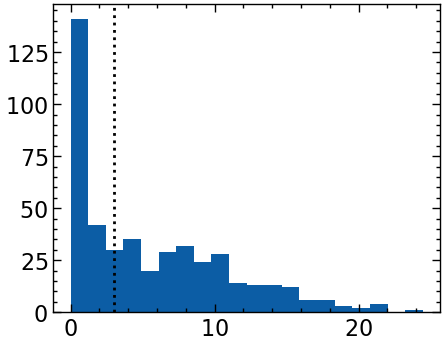

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.hist((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']), bins=20)
ax.axvline(3,0,1,c='k', linestyle='dotted')


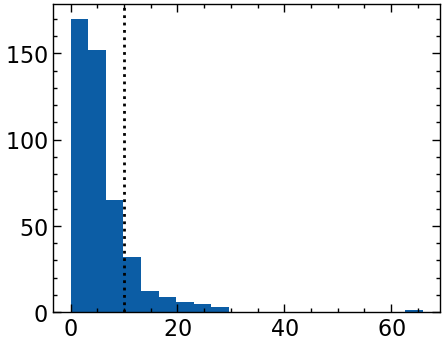

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 4))

ax.hist((results_float['best.reduced_chi_square']), bins=20)
ax.axvline(10,0,1,c='k', linestyle='dotted')


In [ ]:
#results_float

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

hdul = fits.open('./cigale/hsc/fagn1/out/results.fits')
results_fagn1 = hdul[1].data

hdul = fits.open('./cigale/hsc/float/out/results.fits')
results_float = hdul[1].data

hdul = fits.open('./cigale/hsc/fagn0/out/results.fits')
results_fagn0 = hdul[1].data
print(len(results_float))

mask_chi2 = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 3) & (results_float['best.reduced_chi_square'] < 10)
dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']
dM = np.sqrt(dM**2 + (0.24)**2)


fig, ax = plt.subplots(1,1, figsize=(8, 4.5))

#ax.scatter(z[~mask_chi2], np.log10(results_float['bayes.stellar.m_star'][~mask_chi2]),
#             edgecolors='k', c='none', marker='o', alpha=0.5)

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 2
ax.scatter(z[mask_chi2 & mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & mask_spec]),
                c=data_agn['i-mag'][idx_agn2COSMOS20][mask_chi2 & mask_spec],
                marker='o', edgecolors='k', label='spec-z')

im = ax.scatter(z[mask_chi2 & ~mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & ~mask_spec]),
                c=data_agn['i-mag'][idx_agn2COSMOS20][mask_chi2 & ~mask_spec],
                marker='o', label='photo-z')

ax.errorbar(z[mask_chi2], np.log10(results_float['bayes.stellar.m_star'][mask_chi2]),
            yerr=dM[mask_chi2], marker=None, linestyle='none', color='k', zorder=-1, lw=0.8)

print(len(z[mask_chi2]), len(z))


#ax.legend(loc=4, frameon=True)
ax.set_xlabel('Redshift', fontsize=20)
ax.set_ylabel(r'$\log(M_{\ast} / M_{\odot})$', fontsize=20)

#ax.set_xlim(7.5, 12)
ax.set_ylim(7.5, 12)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'HSC $i$ (mag)')



fig.tight_layout()
fig.savefig('massredshift.pdf', dpi=300)

FileNotFoundError: [Errno 2] No such file or directory: './cigale/hsc/fagn1/out/results.fits'

NameError: name 'results_float' is not defined

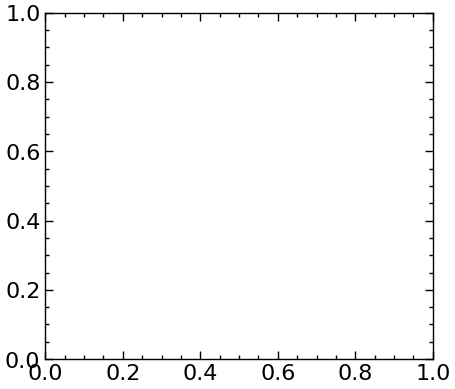

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']
dM_float = np.sqrt(dM**2 + (0.24)**2)

dM = 0.434*results_fagn0['bayes.stellar.m_star_err']/results_fagn0['bayes.stellar.m_star']
dM_fagn0 = np.sqrt(dM**2 + (0.24)**2)

mask = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) < 3)
ax.errorbar(np.log10(results_fagn0['bayes.stellar.m_star'][mask]),
            np.log10(results_float['bayes.stellar.m_star'][mask]),
            xerr=dM_fagn0[mask], yerr=dM_float[mask],
            mfc='none', color='lightcoral', linestyle='none', marker='.', alpha=.8, elinewidth=.5)

ax.scatter(np.log10(results_fagn0['bayes.stellar.m_star'][mask]),
            np.log10(results_float['bayes.stellar.m_star'][mask]),
            color='lightcoral', marker='.')

mask = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 3) & (results_float['best.reduced_chi_square'] < 10)
ax.errorbar(np.log10(results_fagn0['bayes.stellar.m_star'][mask]),
            np.log10(results_float['bayes.stellar.m_star'][mask]),
            xerr=dM_fagn0[mask], yerr=dM_float[mask],
            color='lightskyblue', linestyle='none', marker='.', alpha=.8, elinewidth=.5)

ax.scatter(np.log10(results_fagn0['bayes.stellar.m_star'][mask]),
           np.log10(results_float['bayes.stellar.m_star'][mask]),
           color='lightskyblue', marker='.')


ax.set_xlim(8, 12)
ax.set_ylim(8, 12)

ax.plot([8,12],[8,12], lw=2, color='gray', zorder=-1)

ax.set_xlabel(r'$\log(M_{\ast}/M_{\odot}),\ f_{\rm AGN}=0$')
ax.set_ylabel(r'$\log(M_{\ast}/M_{\odot}),\ f_{\rm AGN}=[0-1]$')

<ipython-input-258-fc332a4905b9>:6: RuntimeWarning: divide by zero encountered in log10
  np.log10(results_float['bayes.stellar.m_star']))


Text(0, 0.5, 'CIGALE')

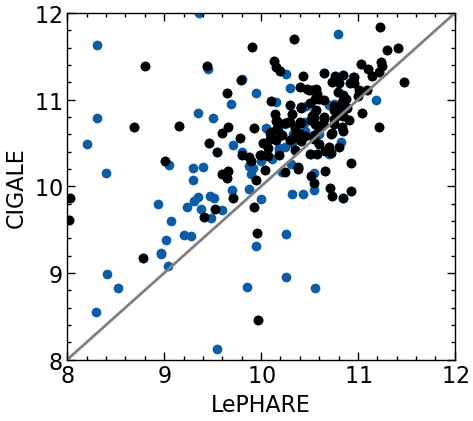

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 3) & (results_float['best.reduced_chi_square'] < 10)

ax.scatter(data_cosmos2020j['lp_mass_med'][idx_COSMOS20],
           np.log10(results_float['bayes.stellar.m_star']))

ax.scatter(data_cosmos2020j['lp_mass_med'][idx_COSMOS20][mask],
           np.log10(results_float['bayes.stellar.m_star'][mask]), color='k')

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)

ax.plot([8,12],[8,12], lw=2, color='gray')

ax.set_xlabel('LePHARE')
ax.set_ylabel('CIGALE')

In [ ]:
len(results_float)

324

In [ ]:
# the selection criterea is simple,  